In [1]:
import datetime
import os
import re
import csv
from lib_log_parse import load_parsed_logs, parse
from typing import List, Optional, Tuple
import numpy as np
from lib_constants import log_no_to_region
from model_publication import Publication
from model_retrieval import Retrieval
import multiprocessing as mp
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

sns.set_theme()

In [2]:
def cdf(series: pd.Series) -> pd.DataFrame:
    return pd.DataFrame.from_dict({
        series.name: np.append(series.sort_values(), series.max()),
        "cdf": np.linspace(0, 1, len(series) + 1)
    })

In [7]:
log_paths = [
    "../data/2023-03-07_plain",
    # "../data/2023-03-07_ignore_gala",
]

In [6]:
for path in log_paths:
    values = []
    for fn in os.listdir(path):
        file_path = os.path.join(path, fn)
        if not os.path.isfile(file_path):
            continue

        if not fn.endswith(".log"):
            continue

        if os.path.exists(file_path + ".p"):
            print(f"Skipping: {file_path}")
            continue

        parse([file_path])
        # values += [[file_path]]

    # with mp.Pool() as pool:
    #     pool.map(parse, values)

Parsing ../data/2023-03-07_plain/plain-node-5.log
Resetting retrieval for Qmbe9HdWe9fi2KkCcNgUwZwJzKMBbiZWRmYngdNhro3vf9
Resetting retrieval for QmeDp8rt6ggQ5yqd6dB5KAquYML1CnJ24GWmAmjC8HYpNz
Resetting retrieval for QmVpLuNhX2FYCyATGck6gToE7GdUshRLMfSosHeQovRx54
cid QmVWRXZ8jmHHCFhLajthXumoE9zJrfm8Mbug9pR8JSZJyJ find node query already done 12D3KooWBnrbh6Aisw67S6Fx3eqdtXzEv8x2HYwgrnnk2xmgh3Xo (n.a.)
cid QmVWRXZ8jmHHCFhLajthXumoE9zJrfm8Mbug9pR8JSZJyJ find node query already done 12D3KooWNN4kEaHujVqfSSRPVYgsHBPyxtabFhHuvKeJi5DnRDFJ (n.a.)
cid QmVWRXZ8jmHHCFhLajthXumoE9zJrfm8Mbug9pR8JSZJyJ find node query already done 12D3KooWSLKvkMpEQ8yrua8MVsH4ePfzTYPagF1M2QGrKaTM3VKe (n.a.)
cid QmVWRXZ8jmHHCFhLajthXumoE9zJrfm8Mbug9pR8JSZJyJ find node query already done 12D3KooWQKUhi4K731veyuBFeheYFX5t1Loq963EKW1FpqgybiyQ (n.a.)
cid QmVWRXZ8jmHHCFhLajthXumoE9zJrfm8Mbug9pR8JSZJyJ find node query already done 12D3KooWBogEu5AFwmkZgdaPhLTESC7Kh3JLmNnS7RirgtAJfUrQ (n.a.)
cid QmVWRXZ8jmHHCFhLajthXumoE9zJrfm8M

In [8]:
results_map = {}
files_map = {}
for i, path in enumerate(log_paths):
    files = []
    for fn in os.listdir(path):
        file_path = os.path.join(path, fn)
        if not os.path.isfile(file_path):
            continue

        if not fn.endswith(".log"):
            continue

        files += [file_path]

    pool = mp.Pool(mp.cpu_count())
    results = pool.map(load_parsed_logs, list(map(lambda x: [x], files)))
    if i == 0:
        print(0, path)
        results_map["plain"] = results
        files_map["plain"] = files
    elif i == 1:
        print(1, path)
        results_map["ignore"] = results
        files_map["ignore"] = files
    else:
        raise Exception("asdf")


0 ../data/2023-03-07_plain


In [9]:
def log_origin(origin: str) -> Optional[Tuple[int, int]]:
    match = re.search(r".*\/plain-node-(\d).log", origin)
    if match is None:
        match = re.search(r".*\/ignore-gala-node-(\d).log", origin)
        if match is None:
            raise Exception("WTF?!")
        return 1, int(match.group(1))

    return 0, int(match.group(1))



def region_from_origin(origin: str) -> str:
    fleet, node = log_origin(origin)
    if fleet == 0:
        return log_no_to_region[node]
    if fleet == 1:
        if node in log_no_to_region:
            return log_no_to_region[node]
        elif node == 6:
            return "hetzner_eu_nbg"
    elif fleet == 2:
        if node in log_no_to_region:
            return log_no_to_region[node]
        elif node == 6:
            return "hetzner_us_ash"
    elif fleet == 3:
        if node in log_no_to_region:
            return log_no_to_region[node]
        elif node == 6:
            return "hetzner_eu_nbg"
        elif node == 7:
            return "hetzner_us_ash"
    raise Exception(f"unknown fleet {fleet} node {node} combination")

results_by_region_map = {}

for key, files in files_map.items():
    results_by_region_map[key] = {}
    for idx, f in enumerate(files):
        region = region_from_origin(f)

        if not region in results_by_region_map[key]:
            results_by_region_map[key][region] = []
        results_by_region_map[key][region] += [results_map[key][idx][0]]

In [10]:
df_retrievals_dict_map ={}
df_publications_dict_map ={}
for key, files in files_map.items():
    df_publications_dict_map[key] = {
        "total_publication_duration": []
    }
    df_retrievals_dict_map[key] = {
        "node": [],
        "region": [],
        "started_at": [],
        "overall_retrieval_duration": [],
        "dht_walks_duration": [],
        "find_first_provider_duration": [],
        "connected_duration": [],
        "received_first_HAVE_duration": [],
        "content_fetch_duration": [],
        "find_provider_queries_count": [],
        "has_error": [],
    }
    publications: List[Publication] = []
    retrievals: List[Retrieval] = []
    for parsed_log in results_map[key]:
        for log in parsed_log:
            publications += log.publications
            retrievals += log.retrievals

    # Remove all retrievals that are marked as invalid
    retrievals = list(
        filter(lambda ret: not ret.marked_as_incomplete, retrievals))
    retrievals = list(filter(lambda ret: ret.state != Retrieval.State.DONE_WITHOUT_ASKING_PEERS, retrievals))

    for pub in publications:
        try:
            df_publications_dict_map[key]["total_publication_duration"] += [pub.duration_total_publication().total_seconds()]
        except:
            print("AAH")
            continue

    for ret in retrievals:
        if ret.stream_opened_at is None or ret.connected_at is None:
            print("skip", ret.stream_opened_at, ret.connected_at)
            continue

        node = log_origin(ret.origin)
        region = region_from_origin(ret.origin)
        # region = region_from_origin(ret.origin)
        if region is None:
            raise Exception("AHH")

        df_retrievals_dict_map[key]["started_at"] += [ret.dial_started_at]
        df_retrievals_dict_map[key]["node"] += [node]
        df_retrievals_dict_map[key]["region"] += [region]
        df_retrievals_dict_map[key]["has_error"] += [ret.done_retrieving_error is not None]

        overall_retrieval_duration = (ret.done_retrieving_at - ret.retrieval_started_at).total_seconds()
        # simulate peer record retrieval by adding the DHT walk duration
        overall_retrieval_duration += ret.get_dht_walk_duration()
        df_retrievals_dict_map[key]["overall_retrieval_duration"] += [overall_retrieval_duration]

        # simulate peer record retrieval by adding the DHT walk duration
        dht_walks_duration = 2 * ret.get_dht_walk_duration()
        df_retrievals_dict_map[key]["dht_walks_duration"] += [dht_walks_duration]

        df_retrievals_dict_map[key]["find_first_provider_duration"] += [(
                                                                       ret.found_first_provider_at - ret.get_providers_queries_started_at).total_seconds()]
        df_retrievals_dict_map[key]["content_fetch_duration"] += [(ret.done_retrieving_at - ret.dial_started_at).total_seconds()]
        df_retrievals_dict_map[key]["find_provider_queries_count"] += [
            len(list(filter(lambda gpq: gpq.started_at > ret.done_retrieving_at, ret.get_providers_queries.values())))]
        df_retrievals_dict_map[key]["connected_duration"] += [(ret.connected_at - ret.get_providers_queries_started_at).total_seconds()]
        df_retrievals_dict_map[key]["received_first_HAVE_duration"] += [(ret.received_first_HAVE_at - ret.get_providers_queries_started_at).total_seconds()]

    # df_retrievals = pd.DataFrame.from_dict(df_retrievals_dict_map[key])

skip None 2023-02-23 15:00:16.979165+00:00
skip None 2023-02-23 15:28:43.230886+00:00
skip None 2023-02-26 14:30:14.613928+00:00
skip None 2023-03-06 12:23:47.381531+00:00
skip None 2023-03-07 05:19:16.448078+00:00
skip None 2023-02-23 06:40:00.953254+00:00
skip None 2023-03-06 12:23:46.524062+00:00
skip None 2023-02-23 15:28:42.953744+00:00
skip None 2023-02-23 15:45:00.257851+00:00
skip None 2023-02-24 05:27:49.537496+00:00
skip None 2023-02-24 16:35:50.868574+00:00
skip None 2023-02-25 22:42:26.032663+00:00
skip None 2023-02-27 17:13:56.922774+00:00
skip None 2023-03-05 15:16:49.326778+00:00
skip None 2023-03-07 05:19:16.007829+00:00
skip None 2023-02-27 14:46:52.728466+00:00
skip None 2023-03-03 15:50:02.422798+00:00
skip None 2023-03-09 13:52:32.573929+00:00
skip None 2023-02-23 06:40:01.695396+00:00
skip None 2023-02-23 15:28:43.137612+00:00
skip None 2023-02-26 14:30:15.159323+00:00
skip None 2023-02-24 15:12:30.526246+00:00


In [11]:
import pickle

with open("df_retrievals_dict_map.p", "wb") as f:
	pickle.dump(df_retrievals_dict_map, f)

with open("df_publications_dict_map.p", "wb") as f:
	pickle.dump(df_publications_dict_map, f)

In [ ]:
with open("df_retrievals_dict_map.p", "rb") as f:
	df_retrievals_dict_map = pickle.load(f)
with open("df_publications_dict_map.p", "rb") as f:
	df_publications_dict_map = pickle.load(f)

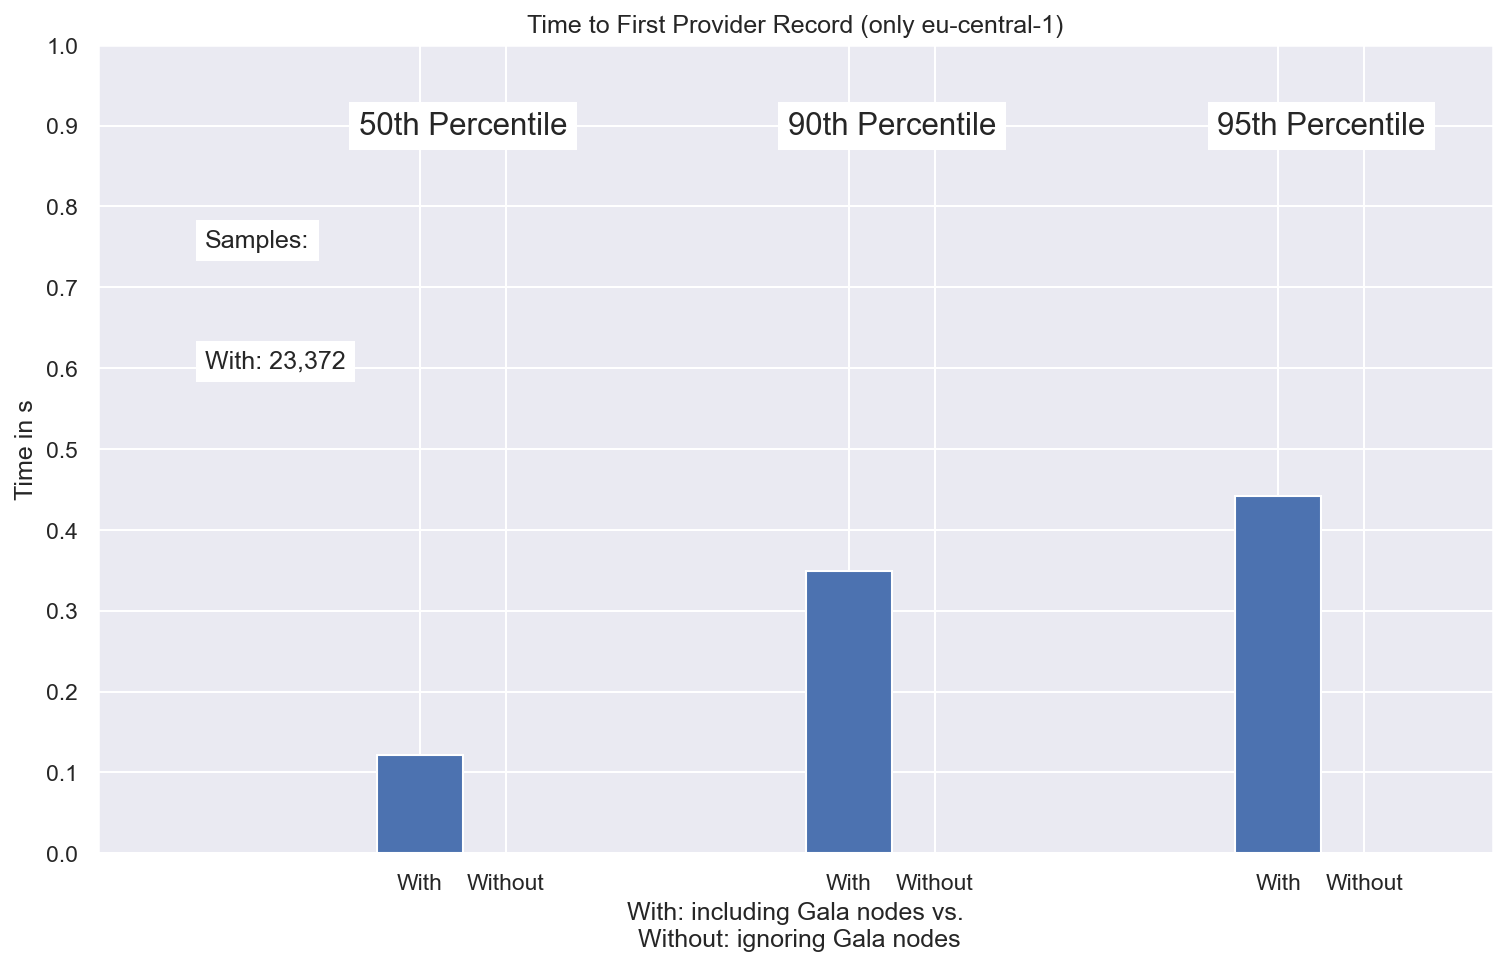

In [13]:
width = 0.2

fig, ax = plt.subplots(figsize=[12, 7], dpi=150)

xticks = []
labels = []
region = "eu_central_1"
sample_counts = {}

df_data = {
    "plain": pd.DataFrame.from_dict(df_retrievals_dict_map["plain"]),
}

for i, percentile in enumerate([50, 90, 95]):

    dat = df_data["plain"]
    dat = dat[dat["region"] == region]
    dat = dat["find_first_provider_duration"]
    sample_counts["With"] = len(dat)
    pre_percentile = np.percentile(dat, percentile)
    ax.bar(i, pre_percentile, width, color="b")

    ax.text(i + width/2, 0.9, f"{percentile}th Percentile", ha="center", va="center", size=15, bbox=dict(fc="w", lw=1))
    xticks += [i, i + width]
    labels += ["With", "Without"]

for i, key in enumerate(sample_counts):
    ax.text(-0.5, 0.05*i + 0.6, f"{key}: {format(sample_counts[key], ',')}",bbox=dict(fc="w", lw=1))

ax.text(-0.5, 0.75, "Samples:",bbox=dict(fc="w", lw=1))

ax.set_title(f"Time to First Provider Record (only eu-central-1)")
ax.set_xlabel("With: including Gala nodes vs.\n Without: ignoring Gala nodes")
ax.set_ylabel("Time in s")
ax.set_xticks(xticks, labels)
ax.set_yticks(np.arange(0, 1.1, 0.1))
ax.set_xlim(-0.75, 2.5)
ax.set_ylim(0, 1)

ax.set_xticks(xticks, labels)


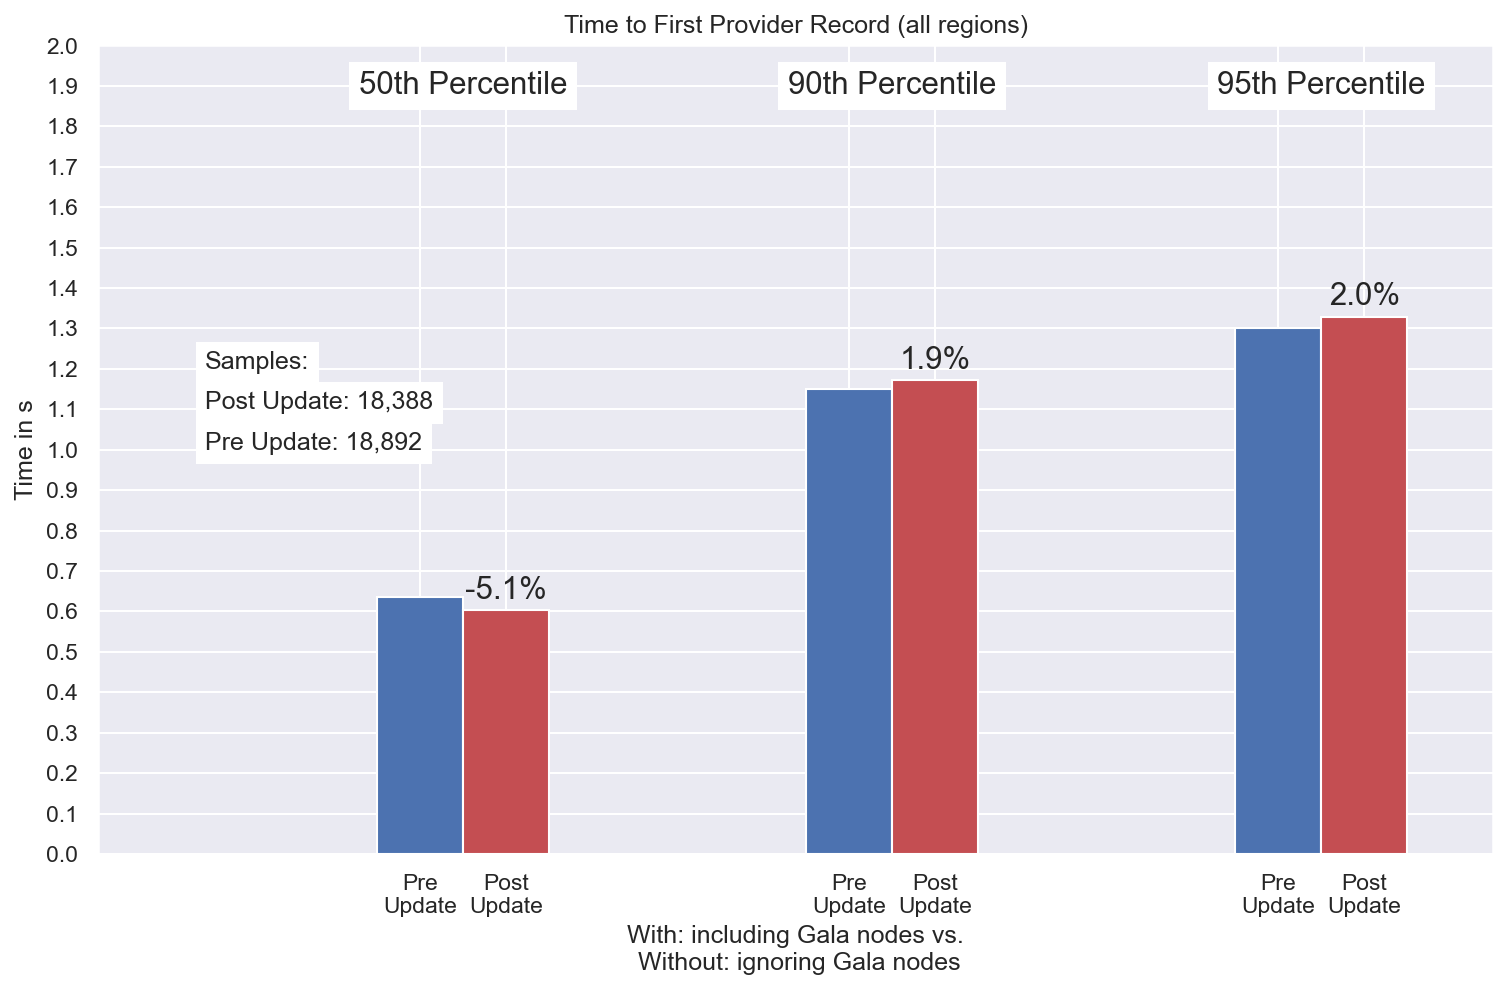

In [13]:
width = 0.2

fig, ax = plt.subplots(figsize=[12, 7], dpi=150)

xticks = []
labels = []
sample_counts = {}
for i, percentile in enumerate([50, 90, 95]):

    dat = df_data["plain"]
    dat = dat["find_first_provider_duration"]
    sample_counts["Pre Update"] = len(dat)
    pre_percentile = np.percentile(dat, percentile)
    ax.bar(i, pre_percentile, width, color="b")

    dat = df_data["ignore"]
    dat = dat["find_first_provider_duration"]
    sample_counts["Post Update"] = len(dat)
    post_percentile = np.percentile(dat, percentile)
    ax.bar(i + width, post_percentile, width, color="r")

    ax.text(i + width, post_percentile + 0.05, f"{post_percentile / pre_percentile - 1:.1%}", ha="center", va="center", size=15)

    ax.text(i + width/2, 1.9, f"{percentile}th Percentile", ha="center", va="center", size=15, bbox=dict(fc="w", lw=1))
    xticks += [i, i + width]
    labels += ["Pre\nUpdate", "Post\nUpdate"]

for i, key in enumerate(sample_counts):
    ax.text(-0.5, 0.1*i + 1, f"{key}: {format(sample_counts[key], ',')}",bbox=dict(fc="w", lw=1))

ax.text(-0.5, 1.2, "Samples:",bbox=dict(fc="w", lw=1))

ax.set_title(f"Time to First Provider Record (all regions)")
ax.set_xlabel("With: including Gala nodes vs.\n Without: ignoring Gala nodes")
ax.set_ylabel("Time in s")
ax.set_xticks(xticks, labels)
ax.set_yticks(np.arange(0, 2.1, 0.1))
ax.set_xlim(-0.75, 2.5)
ax.set_ylim(0, 2)

ax.set_xticks(xticks, labels)
